In [46]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from skimage import measure
import math
from scipy import signal

In [2]:
def nps(i_input):
    # calculates NPS nps for given 2D array i_input
    dim = i_input.shape
    nps = np.zeros(dim)
    n = 1/np.sum(img_gaussian != 0)
    i_input_fft = np.fft.fft2(i_input)
    i_input_fft_centered = np.fft.fftshift(i_input_fft)
    nps = n*(np.abs(i_input_fft_centered)**2)
    return nps

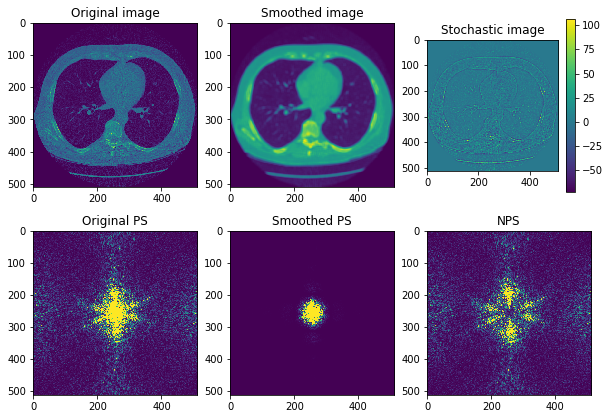

In [94]:
# reading the image, float data type, because if you stick to uint8/uint16 you'll have overflow
# + its important when you calculate difference between filtered and original image you should have
# positive and negative fluctuations and the mean should be approaching 0
# if img-img_gaussian does not approach 0 you'll have a bright dot in center as a constant component 

img = cv2.imread(r"NSP\Synthetic\W_DATA_SET_W0001_PixelCNN.png", 0).astype(np.float64)

# estimating 'stochastic' component by subtracting smoothed img from orig one
img_gaussian = cv2.GaussianBlur(img, (9, 9), 15)
img_stochastic = img - img_gaussian

# NPS
img_nps = nps(img)
img_gaussian_nps = nps(img_gaussian)
img_stochastic_nps = nps(img_stochastic)

# Visualizing
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original image')

plt.subplot(2, 3, 2)
plt.imshow(img_gaussian)
plt.title('Smoothed image')

plt.subplot(2, 3, 3)
plt.imshow(img_stochastic)
plt.colorbar()
plt.title('Stochastic image')

# trick for freq domain - windowing instead of log transform (that's what was in the paper!)
plt.subplot(2, 3, 4)
plt.imshow(img_nps, vmin = 0, vmax = 1000)
plt.title('Original PS')

plt.subplot(2, 3, 5)
plt.imshow(img_gaussian_nps, vmin = 0, vmax = 1000)
plt.title('Smoothed PS')

plt.subplot(2, 3, 6)
plt.imshow(img_stochastic_nps, vmin = 0, vmax = 1000)
plt.title('NPS')

plt.show()

In [118]:
# to compare image sets: calculate the same thing for the whole image set, not for a single image

dirname = r"NSP\Original" 
dim = [512, 512]
pixel_spacing = [1, 1.25]

imgs = np.zeros((len(os.listdir(dirname)), dim[0], dim[1]))
npss = np.zeros((len(os.listdir(dirname)), dim[0], dim[1]))

counter = 0

for item in os.listdir(dirname):
    
    filename = os.path.join(dirname, item)
    img = cv2.imread(filename, 0).astype(np.float64)
    img_gaussian = cv2.GaussianBlur(img, (9, 9), 15)
    img_stochastic = img - img_gaussian
    img_nps = nps(img)
    img_gaussian_nps = nps(img_gaussian)
    img_stochastic_nps = nps(img_stochastic)
    
    imgs[counter, :, :] = img
    npss[counter, :, :] = img_stochastic_nps
    
    counter += 1

# for this - averaged NPSs for the whole set   
# normalization with pixel spacing - to get the result in HU^2*mm^2
npss_ax = pixel_spacing[0]*pixel_spacing[1]*np.mean(npss, axis=0)

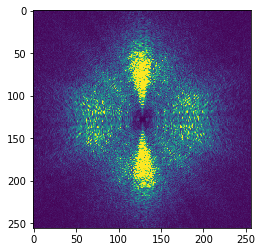

In [119]:
# again, windowing for 'typical' HUs
# the more imgs - the more it looks like donut
# + displaying it in a half of a sample rate [-f_x_s/2:f_x_s/2, -f_y_s/2:f_y_s/2]
f_s = [int(dim[0]/4), int(dim[1]/4)]
plt.imshow(npss_ax[f_s[0]:-f_s[0], f_s[1]:-f_s[1]], vmin = 0, vmax = 1500)
plt.show()

In [120]:
npss_ax_N = npss_ax[f_s[0]:-f_s[0], f_s[1]:-f_s[1]]

steps = 360
R = f_s[0]
x_0 = f_s[0]
y_0 = f_s[1]

nps_profiles_orig = np.zeros((steps, f_s[0]))

for i in range (0, steps):
    alpha = 2*i*math.pi/steps
    (x, y) = (int(x_0+R*math.cos(alpha)), int(y_0+R*math.sin(alpha)))
    profile = measure.profile_line(npss_ax_N, (x_0, y_0), (x, y))
    nps_profiles_orig[i, :] = signal.resample(profile, f_s[0])

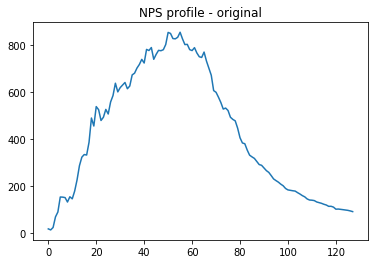

In [121]:
# with conf intervals (fill_between) does not look very nice
nps_profile_orig_mean = np.mean(nps_profiles_orig, axis=0)
#nps_profile_orig_low = np.percentile(nps_profiles_orig, 2.5, axis=0)
#nps_profile_orig_high = np.percentile(nps_profiles_orig, 97.5, axis=0)
plt.plot(nps_profile_orig_mean)
#plt.fill_between(np.linspace(0, f_s[0]-1, num=f_s[0]), nps_profile_orig_low, nps_profile_orig_high, alpha=0.2)
plt.title('NPS profile - original')
plt.show()

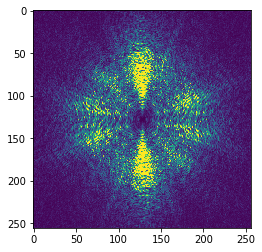

In [122]:
dirname = r"NSP\Synthetic" 
dim = [512, 512]
pixel_spacing = [1, 1.25]

imgs = np.zeros((len(os.listdir(dirname)), dim[0], dim[1]))
npss = np.zeros((len(os.listdir(dirname)), dim[0], dim[1]))

counter = 0

for item in os.listdir(dirname):
    
    filename = os.path.join(dirname, item)
    img = cv2.imread(filename, 0).astype(np.float64)
    img_gaussian = cv2.GaussianBlur(img, (9, 9), 15)
    img_stochastic = img - img_gaussian
    img_nps = nps(img)
    img_gaussian_nps = nps(img_gaussian)
    img_stochastic_nps = nps(img_stochastic)
    
    imgs[counter, :, :] = img
    npss[counter, :, :] = img_stochastic_nps
    
    counter += 1

npss_ax = pixel_spacing[0]*pixel_spacing[1]*np.mean(npss, axis=0)

f_s = [int(dim[0]/4), int(dim[1]/4)]
plt.imshow(npss_ax[f_s[0]:-f_s[0], f_s[1]:-f_s[1]], vmin = 0, vmax = 1500)
plt.show()

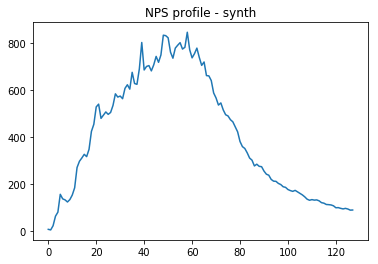

In [123]:
npss_ax_N = npss_ax[f_s[0]:-f_s[0], f_s[1]:-f_s[1]]

steps = 360
R = f_s[0]
x_0 = f_s[0]
y_0 = f_s[1]

nps_profiles_synth = np.zeros((steps, f_s[0]))

for i in range (0, steps):
    alpha = 2*i*math.pi/steps
    (x, y) = (int(x_0+R*math.cos(alpha)), int(y_0+R*math.sin(alpha)))
    profile = measure.profile_line(npss_ax_N, (x_0, y_0), (x, y))
    nps_profiles_synth[i, :] = signal.resample(profile, f_s[0])
    
nps_profile_synth_mean = np.mean(nps_profiles_synth, axis=0)
#nps_profile_synth_low = np.percentile(nps_profiles_synth, 2.5, axis=0)
#nps_profile_synth_high = np.percentile(nps_profiles_synth, 97.5, axis=0)
plt.plot(nps_profile_synth_mean)
#plt.fill_between(np.linspace(0, f_s[0]-1, num=f_s[0]), nps_profile_synth_low, nps_profile_synth_high, alpha=0.2)
plt.title('NPS profile - synth')
plt.show()

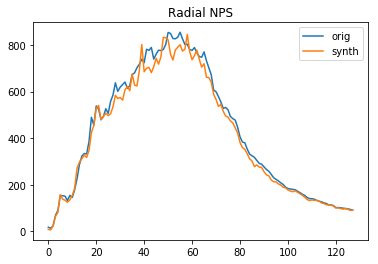

In [124]:
plt.plot(nps_profile_orig_mean, label = 'orig')
plt.plot(nps_profile_synth_mean, label = 'synth')
plt.legend()
plt.title('Radial NPS')
plt.show()

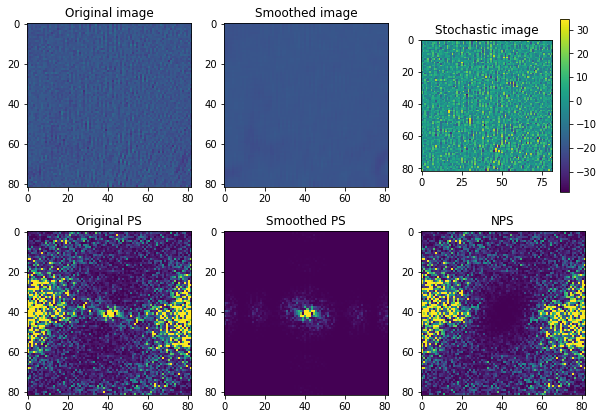

In [7]:
# for local noise

'''img = img[165:-265, 235:-195].astype(np.float64)

img_gaussian = cv2.GaussianBlur(img, (5, 5), 15)
img_stochastic = img - img_gaussian

img_nps = nps(img)
img_gaussian_nps = nps(img_gaussian)
img_stochastic_nps = nps(img_stochastic)

plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
plt.imshow(img, vmin=0, vmax=255)
plt.title('Original image')

plt.subplot(2, 3, 2)
plt.imshow(img_gaussian, vmin=0, vmax=255)
plt.title('Smoothed image')

plt.subplot(2, 3, 3)
plt.imshow(img_stochastic)
plt.colorbar()
plt.title('Stochastic image')

plt.subplot(2, 3, 4)
plt.imshow(img_nps, vmin = 0, vmax = 300)
plt.title('Original PS')

plt.subplot(2, 3, 5)
plt.imshow(img_gaussian_nps, vmin = 0, vmax = 300)
plt.title('Smoothed PS')

plt.subplot(2, 3, 6)
plt.imshow(img_stochastic_nps, vmin = 0, vmax = 300)
plt.title('NPS')

plt.show()'''